In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix


df1 = pd.read_csv("logistic_regression_data.csv", header = None)
df2 = pd.read_csv("votesDataset.csv", header = None)

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def make_meshgrid(x, y, steps=100):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    return xx, yy

def plot_contours(ax, clf, xx, yy, colors=['red', 'blue']):
    labels = clf(np.c_[ xx.ravel(), yy.ravel() ]).reshape(xx.shape)
    out = ax.contourf(xx, yy, labels, levels = np.linspace(0,1,11), cmap=plt.cm.RdBu, alpha=0.5) 
    cbar = plt.colorbar(out)
    return out

# IRLS

In [2]:
class IRLS:
  def __init__(self, P = 1, m0 = None, S0 = None, std_w = 1, n_it = 1, w0 = None):
    self.media = np.array([])
    self.dp = np.array([])
    self.P = P
    self.m0 = m0
    self.S0 = S0
    self.std_w = std_w
    self.w0 = w0
    self.n_it = n_it

  def func_base(self, X):
    if self.P == 0: return X
    novo_X = []
    for i in range(X.shape[0]):
      linha = [1]
      try:
        for elemento in X[i]:
          for pot in range(1, self.P+1):
            linha.append(elemento ** pot)
      except:
        for pot in range(1, self.P+1):
          linha.append(X[i] ** pot)
      novo_X.append(linha)

    return np.array(novo_X)

  def fit(self, X, y):
    X_orig = X
    X = self.func_base(X)
    y = y.reshape(-1,1)

    if self.m0 == None: self.m0 = np.zeros(X.shape[1]).reshape(-1, 1)
    if self.S0 == None: self.S0 = np.eye(X.shape[1]) * self.std_w**2
    if self.w0 == None: self.w0 = np.ones(X.shape[1]).reshape(-1, 1)

    try:
      I = np.eye(X.shape[1])
    except:
      I = np.eye(2)

    m0 = self.m0
    S0 = self.S0
    wi = self.w0

    n,k = X.shape

    std_w = self.std_w


    for i in range(self.n_it):
      Ri = sigmoid(wi.T @ X.T) * (1 - sigmoid(wi.T @ X.T))
      Ri = np.eye(n) * Ri

      A = X.T @ Ri @ X + np.linalg.inv(S0)
      #   (k,1)       (k,k)         (n,k)         (n,1)                   (k,k)             (k,1)
      #   (3,1)       (3,3)         (3,100)         (100,1)                   (3,3)             (3,1)
      wi = wi + np.linalg.inv(A) @ ( X.T @ ( y - sigmoid(X @ wi) ) - np.linalg.inv(S0) @ ( wi - m0 ) )

    self.w0 = wi

  def predict(self, X):
    X = self.func_base(X)
    return sigmoid(X @ self.w0)


# Regressão Logística Bayesiana

In [3]:
class BayesianLogisticRegression:
  def __init__(self, P = 1, m0 = None, S0 = None, std_w = 1, n_it = 1, w0 = None):
    self.media = np.array([])
    self.dp = np.array([])
    self.P = P
    self.m0 = m0
    self.S0 = S0
    self.std_w = std_w
    self.w0 = w0
    self.n_it = n_it

  def func_base(self, X):
    if self.P == 0: return X
    novo_X = []
    for i in range(X.shape[0]):
      linha = [1]
      try:
        for elemento in X[i]:
          for pot in range(1, self.P+1):
            linha.append(elemento ** pot)
      except:
        for pot in range(1, self.P+1):
          linha.append(X[i] ** pot)
      novo_X.append(linha)

    return np.array(novo_X)

  def fit(self, X, y):
    X_orig = X
    X = self.func_base(X)

    if self.m0 == None: self.m0 = np.zeros(X.shape[1]).reshape(-1, 1)
    if self.S0 == None: self.S0 = np.eye(X.shape[1]) * self.std_w**2
    if self.w0 == None: self.w0 = np.ones(X.shape[1]).reshape(-1, 1)

    try:
      I = np.eye(X.shape[1])
    except:
      I = np.eye(2)

    m0 = self.m0
    S0 = self.S0
    wi = self.w0

    n,k = X.shape

    std_w = self.std_w

    model = IRLS(P = self.P, std_w = self.std_w, n_it = self.n_it)
    model.fit(X[:,1:],y)
    self.w0 = model.w0

  def predict(self, X):
    X = self.func_base(X)
    n,m = X.shape
    Ri = sigmoid(self.w0.T @ X.T) * (1 - sigmoid(self.w0.T @ X.T))
    Ri = np.eye(n) * Ri
    H = X.T @ Ri @ X + np.linalg.inv(self.S0)

    media = (X @ self.w0).reshape(1, -1)
    dp = X @ np.linalg.inv(H) @ X.T
    dp = dp.diagonal().reshape(1, -1)

    return sigmoid( np.sqrt(1 + math.pi * dp / 8) * media )




## Testando o modelo

In [4]:
X = df1[[0,1]].to_numpy()
y = df1[2].to_numpy().astype(int)


model = BayesianLogisticRegression(n_it = 10)
model.fit(X,y)
y_pred = model.predict(X)
df = pd.DataFrame()
df["y_real"] = y.reshape(-1)
df["y_prob"] = y_pred.reshape(-1)
acuracia = accuracy_score(y.reshape(-1), np.round(y_pred).reshape(-1))
print("Acurácia:", acuracia)
print(df)

Acurácia: 0.98
    y_real    y_prob
0        0  0.000622
1        0  0.000190
2        0  0.036287
3        1  0.995471
4        0  0.002650
..     ...       ...
95       1  0.885412
96       0  0.016917
97       1  0.975985
98       1  0.845312
99       0  0.186981

[100 rows x 2 columns]


## Distribuiçaõ preditiva

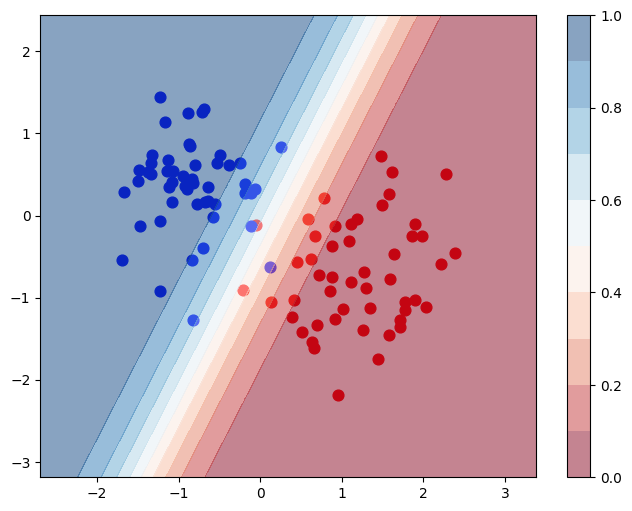

In [5]:
labels = [0,1]
colors = ['red', 'blue']
fig, ax = plt.subplots(figsize=(8,6))
for label in labels:
    plt.scatter(X[y == label,0], X[y == label,1], s=60, marker='o', color=colors[label])
xx, yy = make_meshgrid(X[:,0], X[:,1])
plot_contours(ax, clf=lambda x: model.predict(x), xx=xx, yy=yy, colors=colors)
plt.show()

# Naive Bayes

In [6]:
class NaiveBayes:
  def __init__(self, a = 1, b = 1, alfa = 1, abordagem_alfa = "uniforme"):
    self.a = a
    self.b = b
    self.alfa = alfa
    self.abordagem_alfa = abordagem_alfa

  def fit(self, X, y):
    n,k = X.shape
    c = len(np.unique(y))
    self.c = c
    df = pd.DataFrame(X)
    df["y"] = y

    g1, g2 = df.groupby(by = "y")
    g1 = g1[1].drop("y", axis = 1)
    n1 = len(g1)
    g2 = g2[1].drop("y", axis = 1)
    n2 = len(g2)

    self.matriz_N = np.array(pd.concat([g1.sum(), g2.sum()], axis = 1).astype(int))


    THETA = []
    for d_ in range(k):
      linha = []
      for c_ in range(c):
        linha.append( (self.matriz_N[d_,c_] + self.b) / ([n1,n2][c_] + self.a + self.b) )
      THETA.append(linha)
    self.THETA = np.array(THETA)

    if self.abordagem_alfa == "dados":
      self.alfas = np.array([ n1 / n * self.alfa, n2 / n * self.alfa ])
    else:
      self.alfas = np.ones(c)*self.alfa

    soma_alfas = np.sum( self.alfas )
    self.pesos = np.array( [ ([n1,n2][i] + self.alfas[i]) / (n + soma_alfas) for i in range(c) ] )

  def predict(self, X):
    y_pred = []

    for x in X:
      p_c = []
      for c_ in range(self.c):
        soma = math.log( self.pesos[c_] )
        for d_ in range(X.shape[1]):
          if x[d_] == 1:
            soma += math.log( self.THETA[d_, c_] )
          else:
            soma += math.log( 1 - self.THETA[d_, c_] )
        p_c.append(soma)
      y_pred.append(p_c)
    return np.argmax(np.array(y_pred), axis = 1)

## Testando o modelo

In [7]:
le = LabelEncoder()

X = df2.drop(0, axis = 1).to_numpy()[1:]
y = df2[0].to_numpy()[1:]
y_encoded = le.fit_transform(y)

model = NaiveBayes(a = 1, b = 1, alfa = 1, abordagem_alfa = "dados")
model.fit(X,y_encoded)
y_pred = model.predict(X)

df = pd.DataFrame()
df["y_real"] = y_encoded
df["y_predito"] = y_pred
acuracia = accuracy_score(y_encoded, y_pred)
print("Acurácia:", acuracia)

Acurácia: 0.8896551724137931


## Matriz de confusão

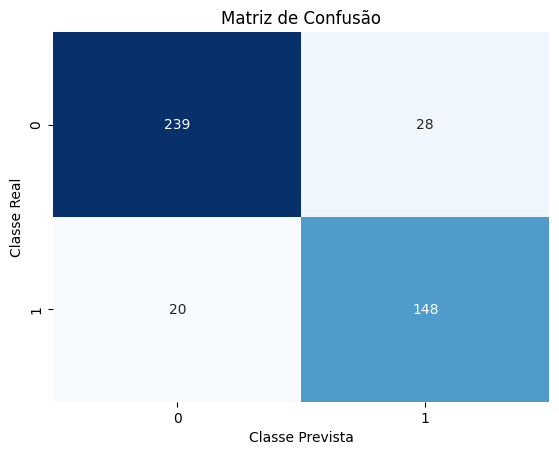

In [8]:
matriz = confusion_matrix(y_encoded, y_pred)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()
